In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shap

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

import lightgbm as lgb

# from context import wfm
import wfm

shap.initjs()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
root_path = Path().resolve().parent
input_path = root_path / "data" / "input"
images_path = root_path / "images"
output_path = root_path / "output"

input_data = wfm.preprocessing.get_input_data(input_path)
input_data.head()

wildfire  id     año material  npisos  h_viv   n_daño orientacio  elevación  \
0  Limache   0  1978.0   Sólido     1.0    2.5  Ninguno          E    67.4828   
1  Limache   0  2004.0  Liviano     1.0    2.5  Ninguno          E    67.9629   
2  Limache   0  2009.0  Liviano     1.0    2.5  Ninguno          E    64.9530   
3  Limache   0  1978.0  Liviano     1.0    2.5  Ninguno          E    61.4631   
4  Limache   0  1978.0   Sólido     1.0    2.5  Ninguno          E    61.5823   

   pendiente  ...  fact_agua  n_conjman  d_conj_man  n_conj10m  d_conj_10m  \
0  11.326300  ...         No          6     10.0000         13     10.0000   
1  10.550100  ...         No          6     10.0000         13     10.0000   
2  10.819000  ...         No          6     10.0000         13     10.0000   
3   0.953306  ...         No          6     10.0000         12     10.0000   
4   0.693135  ...         No          6     23.5041         12     23.5041   

   n_conj20m  d_conj_20m    cord_x     cord_y  \
0          4     20.0000  291295.0  6347530.0   
1          4     20.0000  291301.0  6347550.0   
2          4     20.0000  291300.0  6347520.0   
3          4     20.0000  291334.0  6347500.0   
4          4     37.6067  291371.0  6347510.0   

                                            geometry  
0  POLYGON ((291288.520 6347524.396, 291294.786 6...  
1  POLYGON ((291298.638 6347547.595, 291299.696 6...  
2  POLYGON ((291298.469 6347519.147, 291300.967 6...  
3  POLYGON ((291329.666 6347502.326, 291340.503 6...  
4  POLYGON ((291363.407 6347527.937, 291365.271 6...  

[5 rows x 31 columns]

In [3]:
def get_cat_dict(df, col):
    return dict(zip(df[col], df[col].cat.codes.astype("category")))

In [4]:
# --- Display Data --- 
split_random_state = 42
X_display = (
    input_data.drop(columns=["wildfire", "id", "n_daño", "geometry"])
    .pipe(lambda x: pd.DataFrame(x))
)
y = input_data["n_daño"].astype("category")

# --- Data for Algorithm ---
X = X_display.copy()
cat_codes = {col: X_display.pipe(get_cat_dict, col=col) for col in X_display.select_dtypes("category")}
for col, d in cat_codes.items():
    X.loc[:, col] = X[col].map(d)
# y = y_display.cat.codes||

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=split_random_state
)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"{y_train.size} train records and {y_test.size} test records.")

X shape: (2694, 27)
y shape: (2694,)
1885 train records and 809 test records.


In [5]:
# --- lGBM Structure ---
# train_data =lgb.Dataset(X_train, label=y_train,)
# test_data = lgb.Dataset(X_test, label=y_test)

In [6]:
params = {
#     "max_bin": 512,
    "learning_rate": 0.05,
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "binary_logloss",
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
#     "boost_from_average": True
}

# num_round = 1000

# model = lgb.train(
#     params,
#     train_data,
#     num_round,
#     valid_sets=[test_data],
# #     early_stopping_rounds=50,
#     verbose_eval=1000
# )

model = lgb.LGBMClassifier(**params, random_state=42)
model.fit(X, y)
# model.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=100. Current value: min_data_in_leaf=100


LGBMClassifier(learning_rate=0.05, metric='multi_logloss', min_data=100,
               num_class=3, num_leaves=10, objective='multiclass', verbose=-1)

In [7]:
# y_pred = np.argmax(model.predict(X_test), axis=1)

In [8]:
y_pred = model.predict(X_test)

In [9]:
print(
    classification_report(
        y_test,
        y_pred,
    )
)

              precision    recall  f1-score   support

     Ninguno       1.00      1.00      1.00       727
     Parcial       1.00      1.00      1.00         8
       Total       1.00      1.00      1.00        74

    accuracy                           1.00       809
   macro avg       1.00      1.00      1.00       809
weighted avg       1.00      1.00      1.00       809



In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

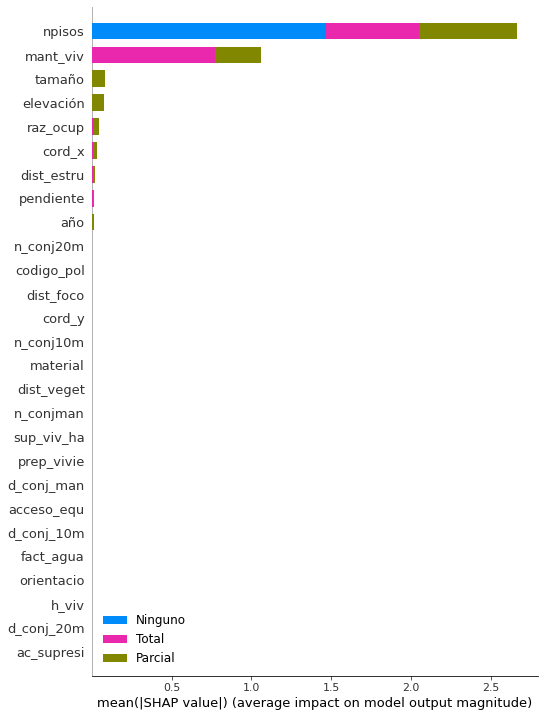

In [12]:
shap.summary_plot(shap_values, X, max_display=X.shape[1], class_names=model.classes_)

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [30]:
"hola".title()

'Hola'

In [14]:
i = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][i, :], X.iloc[i, :])

In [33]:
d = {"a": 1, "b": 2}

In [34]:
{k:v for k, v in d.items()}

{'a': 1, 'b': 2}

In [35]:
dict(d)

{'a': 1, 'b': 2}

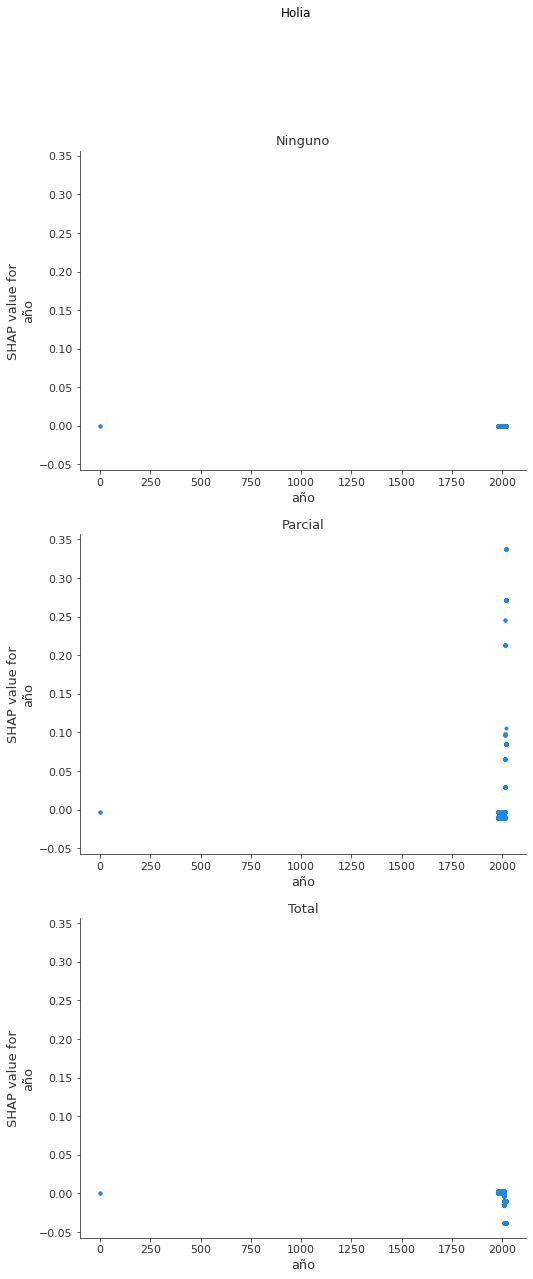

In [32]:
fig, axes = plt.subplots(nrows=3, figsize=(8, 20), sharey=True)
for i, ax in enumerate(axes):
    shap.dependence_plot(
        name,
        shap_values[i],
        X,
        display_features=X_display,
        interaction_index=None,
        title=model.classes_[i],
        ax=ax,
        show=False
    )
fig.suptitle("Holia")
fig.show()

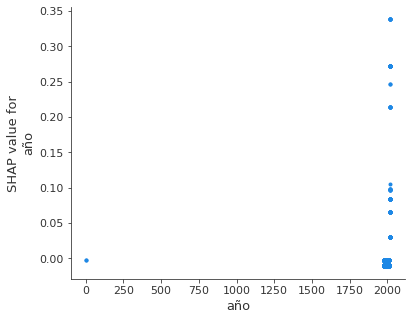

In [17]:
for name in X_train.columns:
    shap.dependence_plot(
        name,
        shap_values[1],
        X,
        display_features=X_display,
        interaction_index=None
    )
    break